In [1]:
from random import randint

import numpy as np

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import accuracy_score # for calculating accuracy of model
import math
import matplotlib.pyplot as plt
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.indicators.hv import HV
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)

In [2]:
# reading csv files
data = pd.read_csv('musk.csv', sep=",")
# data = data.head(2500)

In [3]:
label = pd.DataFrame(data['class'])
data.drop(labels=['class','ID','molecule_name','conformation_name'], axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), columns = data.columns)

In [4]:
class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=166,
                         n_obj=2,
                         n_ieq_constr=1)

    def __classification_error__(self,bitstring):
        featureNames = []
        for i in range(len(bitstring)):
            if bitstring[i] == 1:
                featureNames.append(data.columns[i])

        if len(featureNames) == 0:
            return 1
        trainx = pd.DataFrame(xtrain[featureNames])
        trainy = ytrain
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(trainx, trainy.values.ravel())
        predy = knn.predict(trainx)
        ac = accuracy_score(trainy, predy)
        return 1 - ac

    def __fetures_number__(self,bitstring):
        return sum(bitstring)

    def __constrain__(self,bitstring):
        return 1 - sum(bitstring)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self.__fetures_number__(x[i]) for i in range(0, len(x))]
        f2 = [self.__classification_error__(x[i]) for i in range(0, len(x))]
        g1 = [self.__constrain__(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

In [5]:

f_list = []
pop_list = []
x_list = []
i_f_list = []
i_pop_list = []

    
xtrain, xtest, ytrain, ytest = train_test_split(data, label, test_size=0.3, stratify=label)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain, ytrain.values.ravel())
ypred = knn.predict(xtrain)
ac = accuracy_score(ytrain, ypred)
print("Classification error on training sets using all features: " + str(1 - ac))
ypred = knn.predict(xtest)
ac = accuracy_score(ytest, ypred)
print("Classification error on testing sets using all features: " + str(1 - ac))

print("###################################################################################")
problem = MyProblem()

algorithm = NSGA2(pop_size=100,
                  sampling=BinaryRandomSampling(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               verbose=False,
               save_history=True)
i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
solutions = res.X

Classification error on training sets using all features: 0.025335643135556474
Classification error on testing sets using all features: 0.03080808080808084
###################################################################################


the intial pareto front is plotted as: 


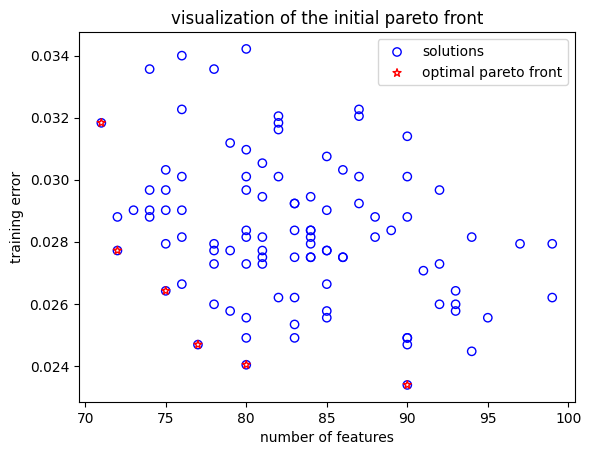

the final pareto front is plotted as: 


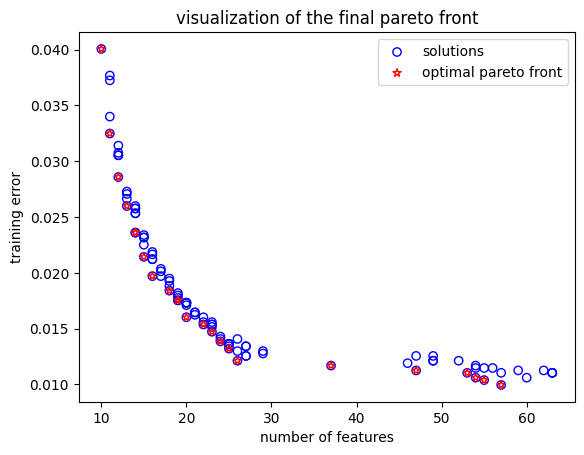

In [6]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

In [7]:
mce_on_train_solution_tnr = []
mce_on_train_tnr = 10
mce_on_test_tnr = 10
mce_on_test_solution_ttr = []
mce_on_test_ttr = 10
mce_on_train_ttr = 10

print("evaluation of the solutions on the final pareto front")
for s in range(len(solutions)):
    solution = solutions[s]
    # print("solution " + str(s) + " with a vector " + str(np.multiply(solution, 1)) + ":")
    print("solution " + str(s) + ":")
    print("number of selected features is: " + str(f[:,0][s]) + " out of 100")
    indices = [i + 1 for i, x in enumerate(np.multiply(solution, 1)) if x == 1]
    print("corresponding indices: " + str(indices))
    print("classification error on train sets: " + str(f[:, 1][s]))
    featureNames = []
    for i in range(len(solution)):
        if solution[i] == 1:
            featureNames.append(data.columns[i])
    trainx = pd.DataFrame(xtrain[featureNames])
    testx = pd.DataFrame(xtest[featureNames])
    trainy = ytrain
    testy = ytest
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(trainx, trainy.values.ravel())
    predy = knn.predict(testx)
    ac = accuracy_score(testy, predy)
    mce = 1-ac
    if f[:, 1][s] < mce_on_train_tnr:
        mce_on_train_tnr = f[:, 1][s]
        mce_on_test_tnr = mce
        mce_on_train_solution_tnr = np.multiply(solution, 1)
    if mce < mce_on_test_ttr:
        mce_on_test_ttr = mce
        mce_on_train_ttr = f[:, 1][s]
        mce_on_test_solution_ttr = np.multiply(solution, 1)
    print("classification error on test sets: " + str(mce))
print("##################################################################################################")

evaluation of the solutions on the final pareto front
solution 0:
number of selected features is: 12.0 out of 100
corresponding indices: [11, 50, 54, 58, 65, 66, 84, 113, 117, 126, 138, 144]
classification error on train sets: 0.02858380251190995
classification error on test sets: 0.04949494949494948
solution 1:
number of selected features is: 10.0 out of 100
corresponding indices: [11, 50, 54, 58, 66, 84, 113, 117, 126, 138]
classification error on train sets: 0.040060632308358546
classification error on test sets: 0.05757575757575761
solution 2:
number of selected features is: 11.0 out of 100
corresponding indices: [11, 50, 54, 58, 66, 84, 113, 117, 126, 138, 144]
classification error on train sets: 0.03248159376353399
classification error on test sets: 0.054545454545454564
solution 3:
number of selected features is: 13.0 out of 100
corresponding indices: [11, 50, 54, 58, 65, 66, 67, 84, 113, 117, 126, 138, 144]
classification error on train sets: 0.025985275010827147
classification 

In [8]:
# print("details of best solution (with minimum classification error) on traning set: ")
# indices = [i + 1 for i, x in enumerate(mce_on_train_solution_tnr) if x == 1]
# print("corresponding indices: " + 
#       str(indices))
# print("number of selected features: " + str(sum(mce_on_train_solution_tnr)))
# print("error rate on training set: " + str(mce_on_train_tnr))
# print("error rate on testing set: " + str(mce_on_test_tnr))

In [9]:
print("details of best solution (with minimum classification error) on testing set: ")
indices = [i + 1 for i, x in enumerate(mce_on_test_solution_ttr) if x == 1]
print("corresponding indices: " + 
      str(indices))
print("number of selected features: " + str(sum(mce_on_test_solution_ttr)))
print("error rate on training set: " + str(mce_on_train_ttr))
print("error rate on testing set: " + str(mce_on_test_ttr))

details of best solution (with minimum classification error) on testing set: 
corresponding indices: [1, 5, 8, 11, 13, 28, 31, 34, 39, 43, 47, 50, 51, 53, 54, 58, 59, 61, 65, 66, 73, 76, 80, 82, 84, 90, 93, 97, 98, 100, 101, 107, 109, 111, 113, 115, 116, 117, 121, 123, 126, 128, 132, 133, 135, 137, 138, 140, 141, 146, 148, 151, 152, 157, 160, 161, 163]
number of selected features: 57
error rate on training set: 0.009961022087483729
error rate on testing set: 0.020707070707070674


In [10]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f = scaler.fit_transform(f)
hv = ind(f)
print("HV of the best pareto front:" + str(round(hv, 2)))

HV of the best pareto front:0.84
